In [1]:
catName = 'low'

In [2]:
import sys, os, pickle, time, re
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from array import array

import ROOT as rt
rt.TGaxis.SetMaxDigits(4)
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import ROOT.RooFit as rf
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from histo_utilities import create_TH1D, create_TH2D, SetMaxToMaxHist
from gridVarQ2Plot import col_dic
from progressBar import ProgressBar
from categoriesDef import categories
cat = categories[catName]

from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1


CMS_lumi.extraText = 5*' ' + 'Internal'

donotdelete = []

Welcome to JupyROOT 6.12/07


In [4]:
label_dic = {'data' : 'Data',
             'mu'   : 'B#rightarrow D*#mu#nu',
             'tau'  : 'B#rightarrow D*#tau#nu',
             'Hc'   : 'B#rightarrow D*H_{c}',
             'Dstst': 'B#rightarrow D**#mu#nu'
            }

In [5]:
m_pi = 0.13957062
m_K = 0.493677
m_D0 = 1.86483
m_Dst = 2.01026

In [6]:
catText = rt.TLatex()
catText.SetTextAlign(31)
catText.SetTextSize(0.06)
catText.SetTextFont(42)
catText.SetTextSize(0.05)

In [7]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [8]:
df = {}

In [9]:
MCsample = {
'mu' : DSetLoader('B0_MuNuDmst_PU20'),
'tau' : DSetLoader('B0_TauNuDmst_PU20'),
'Hc' : DSetLoader('B0_DmstHc_PU20'),
'Dstst' : DSetLoader('Bp_MuNuDstst_PU20')
}

for n, s in MCsample.iteritems():
    df[n] = rtnp.root2array(s.skimmed_dir + '/{}_skip17_corr.root'.format(cat.name))

In [10]:
dataDir = '../data/cmsRD'
df['data'] = rtnp.root2array(dataDir + '/skimmed/B2DstMu_200416_{}_skip17_corr.root'.format(cat.name))
datasets_loc = glob(dataDir + '/ParkingBPH*/*2018*B2DstMu_200410*')
lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=True)
CMS_lumi.integrated_lumi = lumi_tot

Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200410
HLT_Mu7_IP4_part2_v2 1.28
Run2018C-05May2019-v1_RDntuplizer_B2DstMu_200410
HLT_Mu7_IP4_part2_v2 0.03
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200410
HLT_Mu7_IP4_part1_v2 1.28
Run2018C-05May2019-v1_RDntuplizer_B2DstMu_200410
HLT_Mu7_IP4_part1_v2 0.03
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200410
HLT_Mu7_IP4_part4_v2 1.28
Run2018C-05May2019-v1_RDntuplizer_B2DstMu_200410
HLT_Mu7_IP4_part4_v2 0.03
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200410
HLT_Mu7_IP4_part3_v2 1.28
Run2018C-05May2019-v1_RDntuplizer_B2DstMu_200410
HLT_Mu7_IP4_part3_v2 0.03
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200410
HLT_Mu7_IP4_part0_v2 1.27
Run2018C-05May2019-v1_RDntuplizer_B2DstMu_200410
HLT_Mu7_IP4_part0_v2 0.03
Total lumi: 6.54 fb^-1


# General plots

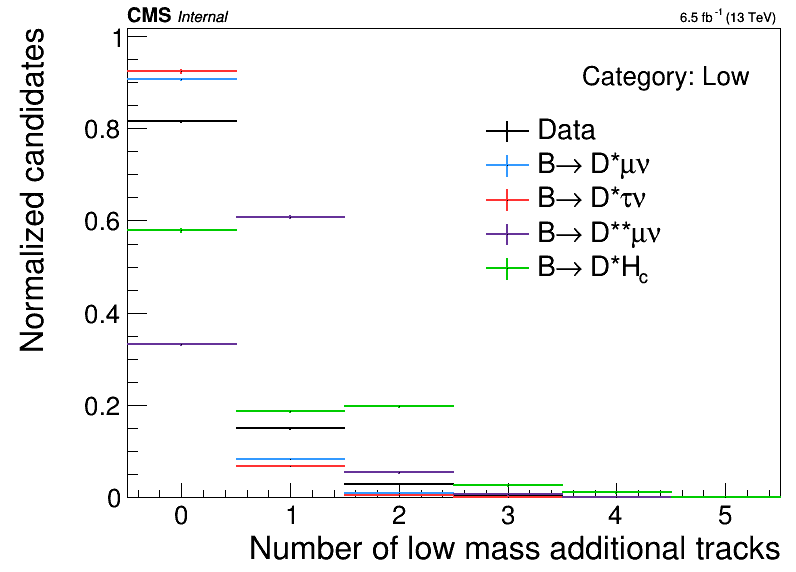

In [11]:
h = create_TH1D(df['data']['N_goodAddTks'], 'data', 
                binning=[6, -0.5, 5.5],
                axis_title=['Number of low mass additional tracks', 'Normalized candidates'],
                scale_histo='norm'
               )
hl = [h]
leg = rt.TLegend(0.6, 0.5, 0.9, 0.8)
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
leg.AddEntry(h, label_dic['data'], 'lep')
for n in MCsample.keys():
    h = create_TH1D(df[n]['N_goodAddTks'], n, 
                binning=h.binning,
                scale_histo='norm'
               )
    h.SetLineColor(col_dic[n])
    leg.AddEntry(h, label_dic[n], 'lep')
    hl.append(h)

m = SetMaxToMaxHist(hl)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
leg.Draw()

In [12]:
for n in MCsample.keys():
    eff = np.sum(df[n]['tkPt_0'] < 0.8)/float(df[n]['tkPt_0'].shape[0])
    print n, '{:.3f}'.format(eff)

mu 0.954
tau 0.956
Dstst 0.393
Hc 0.623


In [13]:
for n in MCsample.keys():
    eff = np.sum(df[n]['N_goodAddTks'] == 0)/float(df[n]['tkPt_0'].shape[0])
    print n, '{:.3f}'.format(eff)

mu 0.907
tau 0.925
Dstst 0.332
Hc 0.579


# D** side

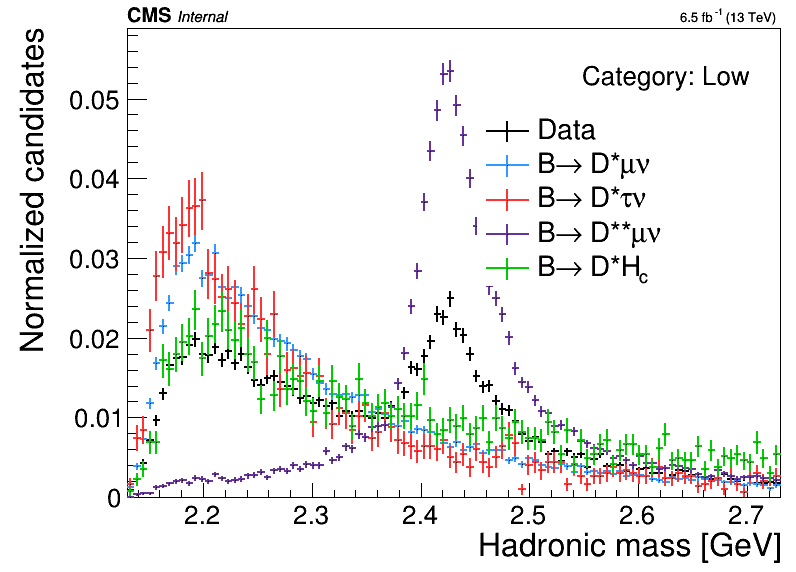

In [14]:
sel = df['data']['N_goodAddTks'] == 1
h = create_TH1D(df['data']['tkMassHad_0'][sel], 'dataNorm', 
                binning=[100, 2.13, 2.73],
                axis_title=['Hadronic mass [GeV]', 'Normalized candidates'],
                scale_histo='norm'
               )
h_fit = {}
hdataf = h.Clone('data')
hdataf.Scale(np.sum(sel))
h_fit['data'] = hdataf
hl = [h]
leg = rt.TLegend(0.6, 0.5, 0.9, 0.8)
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
leg.AddEntry(h, label_dic['data'], 'lep')
for n in MCsample.keys():
    sel = df[n]['N_goodAddTks'] == 1
    h = create_TH1D(df[n]['tkMassHad_0'][sel], n, 
                binning=h.binning,
                scale_histo='norm'
               )
    h.SetLineColor(col_dic[n])
    leg.AddEntry(h, label_dic[n], 'lep')
    hl.append(h)
    h_fit[n] = h

m = SetMaxToMaxHist(hl)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
leg.Draw()

data: 32.7%
mu : 45.6%
tau : 41.1%
Dstst : 2.5%
Hc : 38.5%


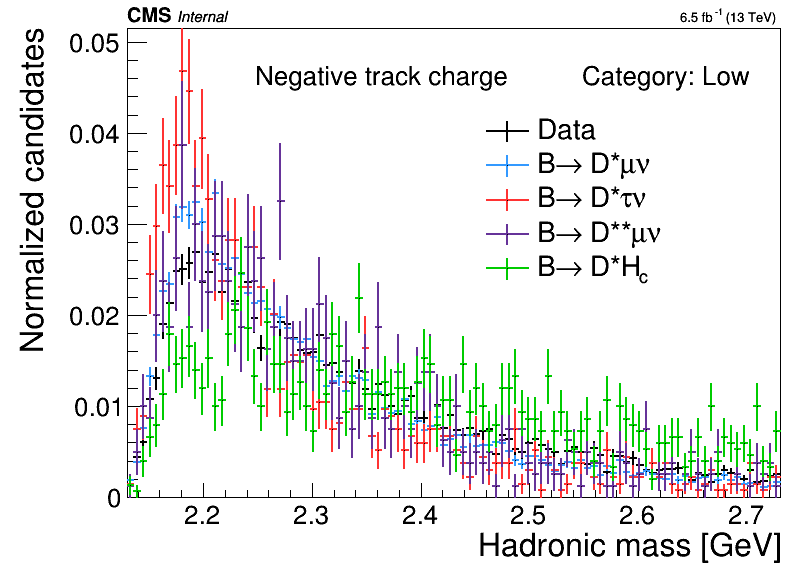

In [15]:
sel = np.logical_and(df['data']['N_goodAddTks'] == 1, df['data']['tkCharge_0'] < 0)
print 'data: {:.1f}%'.format(100*float(np.sum(sel))/ np.sum(df['data']['N_goodAddTks'] == 1))
h = create_TH1D(df['data']['tkMassHad_0'][sel], 'dataNorm', 
                binning=[100, 2.13, 2.73],
                axis_title=['Hadronic mass [GeV]', 'Normalized candidates'],
                scale_histo='norm'
               )
hdataf = h.Clone('data')
hdataf.Scale(np.sum(sel))
hl = [h]
leg = rt.TLegend(0.6, 0.5, 0.9, 0.8)
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
leg.AddEntry(h, label_dic['data'], 'lep')
for n in MCsample.keys():
    sel = np.logical_and(df[n]['N_goodAddTks'] == 1, df[n]['tkCharge_0'] < 0)
    print n, ': {:.1f}%'.format(100*float(np.sum(sel))/ np.sum(df[n]['N_goodAddTks'] == 1))
    h = create_TH1D(df[n]['tkMassHad_0'][sel], n, 
                binning=h.binning,
                scale_histo='norm'
               )
    h.SetLineColor(col_dic[n])
    leg.AddEntry(h, label_dic[n], 'lep')
    hl.append(h)

m = SetMaxToMaxHist(hl)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
catText.DrawLatexNDC(0.65, 0.85, 'Negative track charge')
h.Sumw2()
leg.Draw()

data: 67.3%
mu : 54.4%
tau : 58.9%
Dstst : 97.5%
Hc : 61.5%


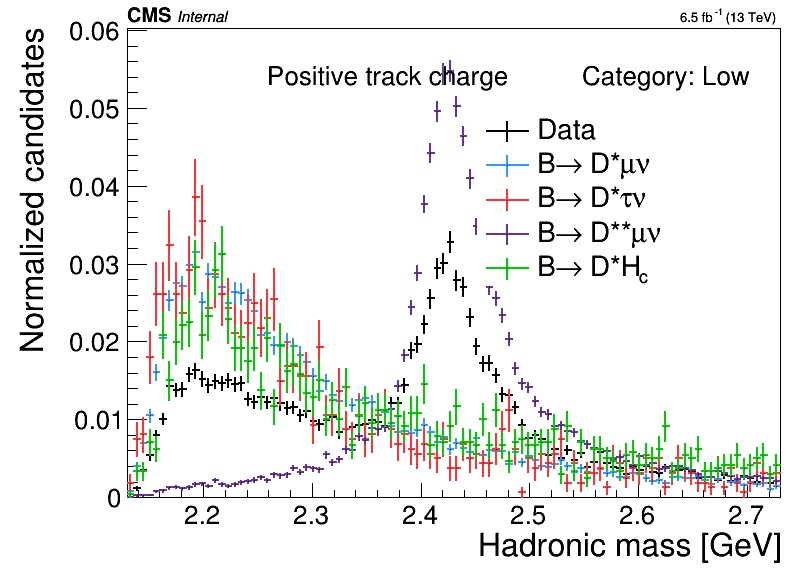

In [16]:
sel = np.logical_and(df['data']['N_goodAddTks'] == 1, df['data']['tkCharge_0'] > 0)
print 'data: {:.1f}%'.format(100*float(np.sum(sel))/ np.sum(df['data']['N_goodAddTks'] == 1))
h = create_TH1D(df['data']['tkMassHad_0'][sel], 'dataNorm', 
                binning=[100, 2.13, 2.73],
                axis_title=['Hadronic mass [GeV]', 'Normalized candidates'],
                scale_histo='norm'
               )
h_fit = {}
hdataf = h.Clone('data')
hdataf.Scale(np.sum(sel))
h_fit['data'] = hdataf
hl = [h]
leg = rt.TLegend(0.6, 0.5, 0.9, 0.8)
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
leg.AddEntry(h, label_dic['data'], 'lep')
for n in MCsample.keys():
    sel = np.logical_and(df[n]['N_goodAddTks'] == 1, df[n]['tkCharge_0'] > 0)
    print n, ': {:.1f}%'.format(100*float(np.sum(sel))/ np.sum(df[n]['N_goodAddTks'] == 1))
    h = create_TH1D(df[n]['tkMassHad_0'][sel], n, 
                binning=h.binning,
                scale_histo='norm'
               )
    h.SetLineColor(col_dic[n])
    leg.AddEntry(h, label_dic[n], 'lep')
    hl.append(h)
    h_fit[n] = h

m = SetMaxToMaxHist(hl)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
catText.DrawLatexNDC(0.65, 0.85, 'Positive track charge')
h.Sumw2()
leg.Draw()

In [17]:
M = rt.RooRealVar('M', 'Hadronic Mass', h.binning[1], h.binning[2], 'GeV')

data = rt.RooDataHist('Data', 'Data', rt.RooArgList(M), h_fit['data'])
N_data = h_fit['data'].Integral()

dh_mu = rt.RooDataHist('dh_mu', 'mu', rt.RooArgList(M), h_fit['mu'])
pdf_mu = rt.RooHistPdf('pdf_mu', 'pdf_mu', rt.RooArgSet(M), dh_mu)
n_mu = rt.RooRealVar('n_mu', 'N_{#mu}', N_data*0.1, 0, N_data)


dh_Hc = rt.RooDataHist('dh_Hc', 'Hc', rt.RooArgList(M), h_fit['Hc'])
pdf_Hc = rt.RooHistPdf('pdf_Hc', 'pdf_Hc', rt.RooArgSet(M), dh_Hc)
n_Hc = rt.RooRealVar('n_Hc', 'N_{Hc}', 0.5*N_data, 0, N_data)

dh_Dstst = rt.RooDataHist('dh_Dstst', 'Dstst', rt.RooArgList(M), h_fit['Dstst'])
pdf_Dstst = rt.RooHistPdf('pdf_Dstst', 'pdf_Dstst', rt.RooArgSet(M), dh_Dstst)
n_Dstst = rt.RooRealVar('n_Dstst', 'N_{D**}', 0.5*N_data, 0, N_data)

pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_mu, pdf_Hc, pdf_Dstst), rt.RooArgList(n_mu, n_Hc, n_Dstst))
fr = pdf_tot.fitTo(data, rf.PrintLevel(-1), rf.Save())

dof = h.GetNbinsX()-fr.floatParsFinal().getSize()
chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
pval = rt.ROOT.Math.chisquared_cdf_c(chi2.getVal(), dof)
print 'chi2: {:.1f}/{:.0f} {:.3f}'.format(chi2.getVal(), dof, pval)

print 'Total:\nND** = {:.0f} +/- {:.0f} [{:.1f}%]'.format(n_Dstst.getVal(), n_Dstst.getError(), 100*n_Dstst.getError()/n_Dstst.getVal())
print 'Nmu = {:.0f}'.format(n_Dstst.getVal(), n_mu.getVal())
print 'NHc = {:.0f} +/- {:.0f} [{:.1f}%]'.format(n_Hc.getVal(), n_Hc.getError(), 100*n_Hc.getError()/n_Hc.getVal())

chi2: 164.3/97 0.000
Total:
ND** = 9801 +/- 143 [1.5%]
Nmu = 9801
NHc = 614 +/- 391 [63.7%]


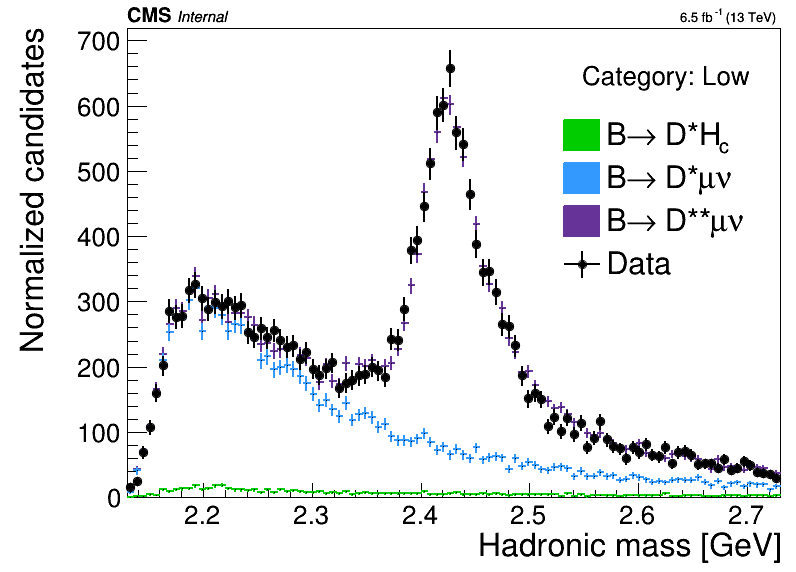

In [18]:
leg = rt.TLegend(0.7, 0.5, 0.95, 0.8)
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

h = h_fit['Hc'].Clone('Hcaux')
h.Scale(n_Hc.getVal())
h.SetFillStyle(1)
h.SetFillColor(col_dic['Hc'])
hl=[h]
leg.AddEntry(h, label_dic['Hc'], 'f')

h = h_fit['mu'].Clone('muaux')
h.Scale(n_mu.getVal())
h.SetFillStyle(1)
h.SetFillColor(col_dic['mu'])
h.Add(hl[0])
hl = [h] + hl
leg.AddEntry(h, label_dic['mu'], 'f')

h = h_fit['Dstst'].Clone('Dststaux')
h.Scale(n_Dstst.getVal())
h.SetFillStyle(1)
h.SetFillColor(col_dic['Dstst'])
h.Add(hl[0])
hl = [h] + hl
leg.AddEntry(h, label_dic['Dstst'], 'f')

leg.AddEntry(h_fit['data'], label_dic['data'], 'lep')
h_fit['data'].SetMarkerStyle(rt.kFullCircle)

m = SetMaxToMaxHist(hl)
c = drawOnCMSCanvas(CMS_lumi, [h_fit['data']] + hl + [h_fit['data']], 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
leg.Draw()

# Hc side

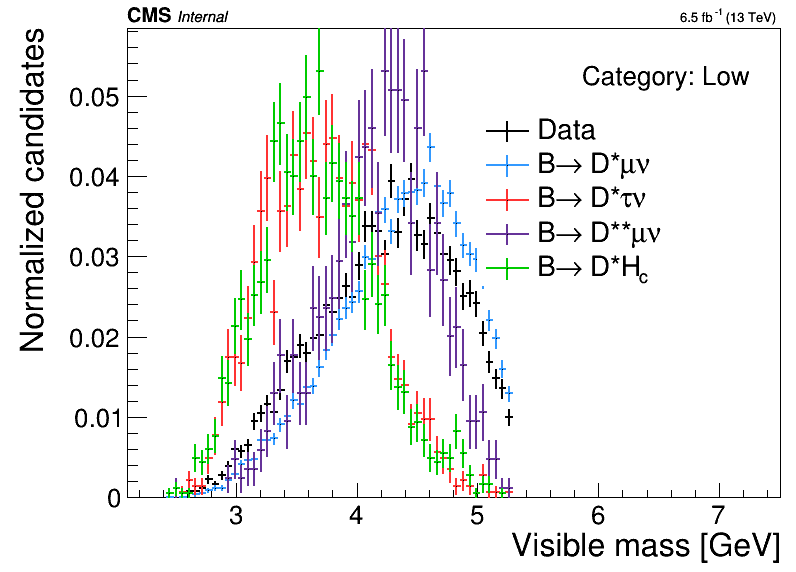

In [19]:
sel = np.logical_and(df['data']['N_goodAddTks'] == 1, df['data']['tkCharge_0'] < 0)
h = create_TH1D(df['data']['tkMassVis_0'][sel], 
                'dataNorm', 
                binning=[100, 2.1, 7.5],
                axis_title=['Visible mass [GeV]', 'Normalized candidates'],
                scale_histo='norm'
               )
h_fit = {}
hdataf = h.Clone('data')
hdataf.Scale(np.sum(sel))
h_fit['data'] = hdataf
hl = [h]
leg = rt.TLegend(0.6, 0.5, 0.9, 0.8)
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
leg.AddEntry(h, label_dic['data'], 'lep')
for n in MCsample.keys():
    sel = np.logical_and(df[n]['N_goodAddTks'] == 1, df[n]['tkCharge_0'] < 0)
    h = create_TH1D(df[n]['tkMassVis_0'][sel], n, 
                binning=h.binning,
                scale_histo='norm'
               )
    h.SetLineColor(col_dic[n])
    leg.AddEntry(h, label_dic[n], 'lep')
    hl.append(h)
    h_fit[n] = h

m = SetMaxToMaxHist(hl)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
leg.Draw()

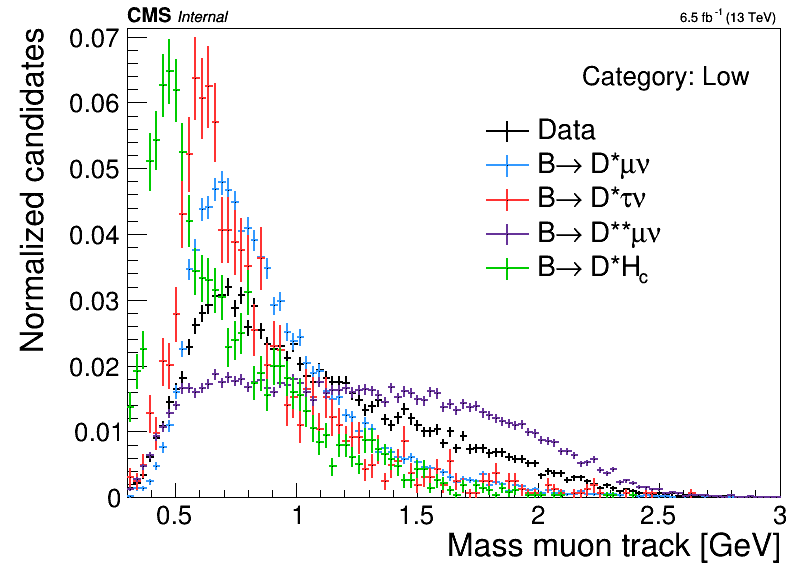

In [20]:
sel = np.logical_and(df['data']['N_goodAddTks'] == 1, df['data']['tkCharge_0'] > 0)
h = create_TH1D(df['data']['tkMassMuTk_0'][sel], 
                'dataNorm', 
                binning=[100, 0.3, 3.],
                axis_title=['Mass muon track [GeV]', 'Normalized candidates'],
                scale_histo='norm'
               )
hl = [h]
leg = rt.TLegend(0.6, 0.5, 0.9, 0.8)
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
leg.AddEntry(h, label_dic['data'], 'lep')
for n in MCsample.keys():
    sel = np.logical_and(df[n]['N_goodAddTks'] == 1, df[n]['tkCharge_0'] > 0)
    h = create_TH1D(df[n]['tkMassMuTk_0'][sel], n, 
                binning=h.binning,
                scale_histo='norm'
               )
    h.SetLineColor(col_dic[n])
    leg.AddEntry(h, label_dic[n], 'lep')
    hl.append(h)

m = SetMaxToMaxHist(hl)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
leg.Draw()

mu 55.7
Dstst 51.3
Hc 95.4


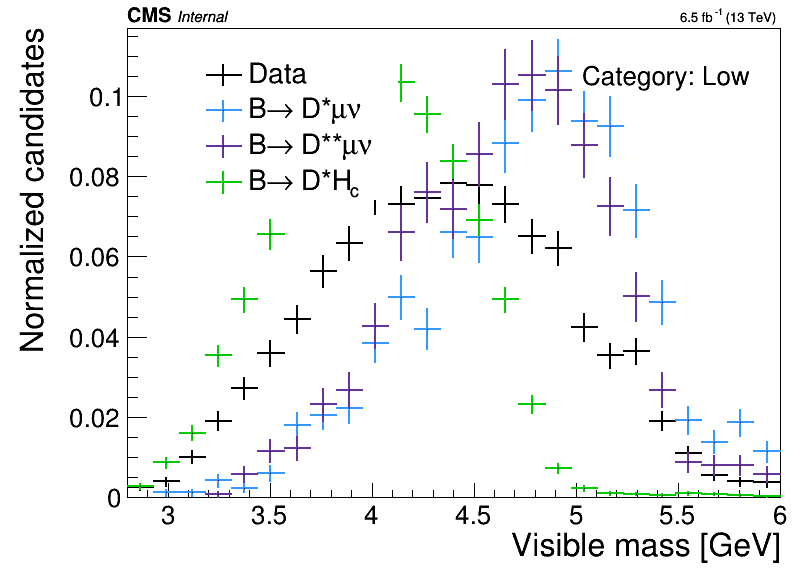

In [44]:
sel = np.logical_and(df['data']['N_goodAddTks'] == 2, df['data']['tkCharge_0']*df['data']['tkCharge_1'] < 0)
h = create_TH1D(df['data']['tkMassVis12'][sel], 
                'dataNorm',
                binning=[25, 2.8, 6],
                axis_title=['Visible mass [GeV]', 'Normalized candidates'],
                scale_histo='norm'
               )
h_fit = {}
hdataf = h.Clone('data')
hdataf.Scale(np.sum(sel))
h_fit['data'] = hdataf
hl = [h]
leg = rt.TLegend(0.25, 0.65, 0.5, 0.9)
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
leg.AddEntry(h, label_dic['data'], 'lep')
for n in MCsample.keys():
    if n in ['tau']: continue
    sel = np.logical_and(df[n]['N_goodAddTks'] == 2, df[n]['tkCharge_0']*df[n]['tkCharge_1'] < 0)
    print n, '{:.1f}'.format(100.0*np.sum(sel)/float(np.sum(df[n]['N_goodAddTks'] == 2)))
    h = create_TH1D(df[n]['tkMassVis12'][sel], n, 
                binning=h.binning,
                scale_histo='norm'
               )
    h.SetLineColor(col_dic[n])
    leg.AddEntry(h, label_dic[n], 'lep')
    hl.append(h)
    h_fit[n] = h

m = SetMaxToMaxHist(hl)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
leg.Draw()

In [45]:
M = rt.RooRealVar('M', 'Hadronic Mass', h.binning[1], h.binning[2], 'GeV')

data = rt.RooDataHist('Data', 'Data', rt.RooArgList(M), h_fit['data'])
N_data = h_fit['data'].Integral()

dh_mu = rt.RooDataHist('dh_mu', 'mu', rt.RooArgList(M), h_fit['mu'])
pdf_mu = rt.RooHistPdf('pdf_mu', 'pdf_mu', rt.RooArgSet(M), dh_mu)
n_mu = rt.RooRealVar('n_mu', 'N_{#mu}', N_data*0.5, 0, N_data)


dh_Hc = rt.RooDataHist('dh_Hc', 'Hc', rt.RooArgList(M), h_fit['Hc'])
pdf_Hc = rt.RooHistPdf('pdf_Hc', 'pdf_Hc', rt.RooArgSet(M), dh_Hc)
n_Hc = rt.RooRealVar('n_Hc', 'N_{Hc}', 0.5*N_data, 0, N_data)

dh_Dstst = rt.RooDataHist('dh_Dstst', 'Dstst', rt.RooArgList(M), h_fit['Dstst'])
pdf_Dstst = rt.RooHistPdf('pdf_Dstst', 'pdf_Dstst', rt.RooArgSet(M), dh_Dstst)
n_Dstst = rt.RooRealVar('n_Dstst', 'N_{D**}', 0.01*N_data, 0, N_data)

pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_mu, pdf_Hc, pdf_Dstst), rt.RooArgList(n_mu, n_Hc, n_Dstst))
fr = pdf_tot.fitTo(data, rf.PrintLevel(-1), rf.Save())

dof = h.GetNbinsX()-fr.floatParsFinal().getSize()
chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
pval = rt.ROOT.Math.chisquared_cdf_c(chi2.getVal(), dof)
print 'chi2: {:.1f}/{:.0f} {:.3f}'.format(chi2.getVal(), dof, pval)

print 'Total:\nND** = {:.0f} +/- {:.0f} [{:.1f}%]'.format(n_Dstst.getVal(), n_Dstst.getError(), 100*n_Dstst.getError()/n_Dstst.getVal())
print 'Nmu = {:.0f}'.format(n_mu.getVal())
print 'NHc = {:.0f} +/- {:.0f} [{:.1f}%]'.format(n_Hc.getVal(), n_Hc.getError(), 100*n_Hc.getError()/n_Hc.getVal())

chi2: 37.1/22 0.023
Total:
ND** = 1066 +/- 214 [20.1%]
Nmu = 894
NHc = 1874 +/- 65 [3.4%]


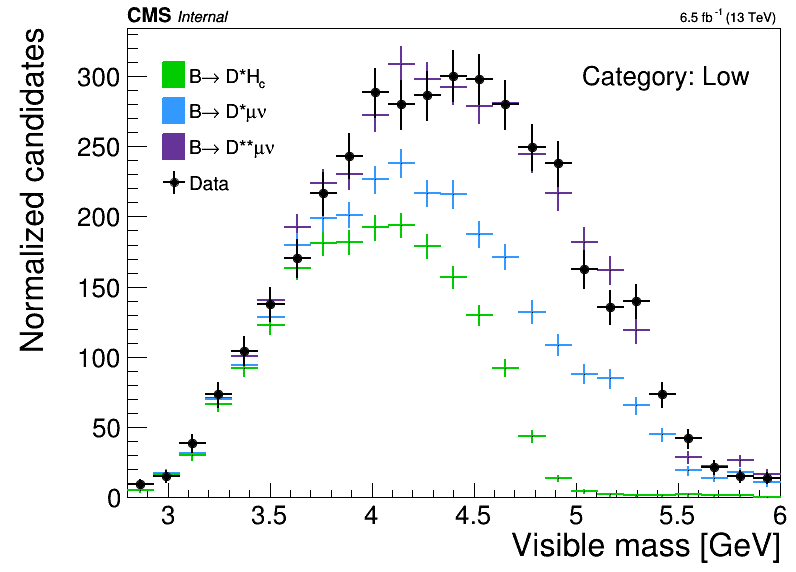

In [47]:
leg = rt.TLegend(0.2, 0.65, 0.35, 0.9)
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

h = h_fit['Hc'].Clone('Hcaux')
h.Scale(n_Hc.getVal())
h.SetFillStyle(1)
h.SetFillColor(col_dic['Hc'])
hl=[h]
leg.AddEntry(h, label_dic['Hc'], 'f')

h = h_fit['mu'].Clone('muaux')
h.Scale(n_mu.getVal())
h.SetFillStyle(1)
h.SetFillColor(col_dic['mu'])
h.Add(hl[0])
hl = [h] + hl
leg.AddEntry(h, label_dic['mu'], 'f')

h = h_fit['Dstst'].Clone('Dststaux')
h.Scale(n_Dstst.getVal())
h.SetFillStyle(1)
h.SetFillColor(col_dic['Dstst'])
h.Add(hl[0])
hl = [h] + hl
leg.AddEntry(h, label_dic['Dstst'], 'f')

leg.AddEntry(h_fit['data'], label_dic['data'], 'lep')
h_fit['data'].SetMarkerStyle(rt.kFullCircle)

m = SetMaxToMaxHist(hl)
c = drawOnCMSCanvas(CMS_lumi, [h_fit['data']] + hl + [h_fit['data']], 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
leg.Draw()

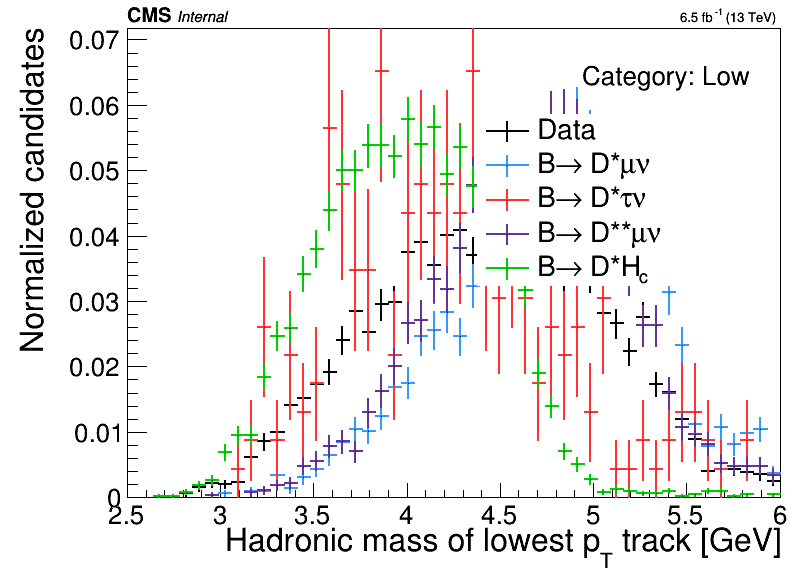

In [22]:
sel = df['data']['N_goodAddTks'] == 2
h = create_TH1D(df['data']['tkMassVis12'][sel], 
                'dataNorm', 
                binning=[50, 2.5, 6.],
                axis_title=['Hadronic mass of lowest p_{T} track [GeV]', 'Normalized candidates'],
                scale_histo='norm'
               )
hl = [h]
leg = rt.TLegend(0.6, 0.5, 0.9, 0.8)
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
leg.AddEntry(h, label_dic['data'], 'lep')
for n in MCsample.keys():
    sel = df[n]['N_goodAddTks'] == 2
    h = create_TH1D(df[n]['tkMassVis12'][sel], n, 
                binning=h.binning,
                scale_histo='norm'
               )
    h.SetLineColor(col_dic[n])
    leg.AddEntry(h, label_dic[n], 'lep')
    hl.append(h)

m = SetMaxToMaxHist(hl)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
leg.Draw()

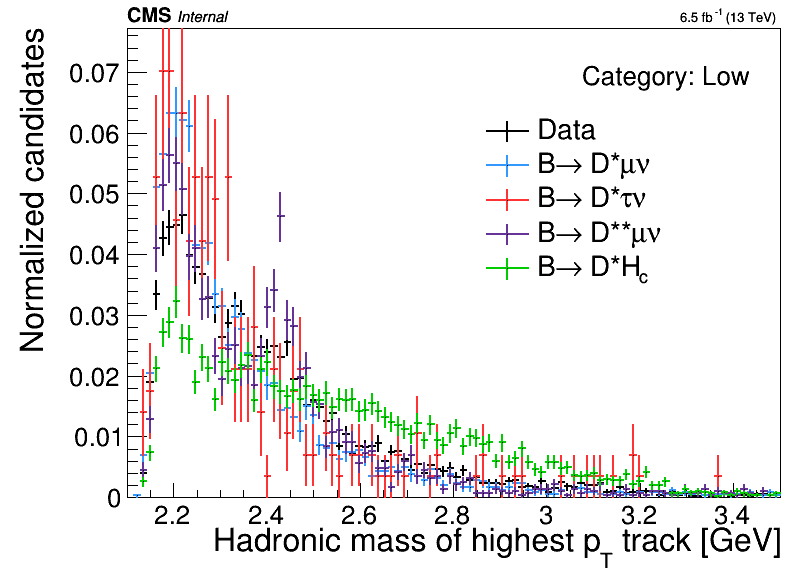

In [23]:
sel = df['data']['N_goodAddTks'] == 2
h = create_TH1D(df['data']['tkMassHad_1'][sel], 
                'dataNorm', 
                binning=[100, 2.1, 3.5],
                axis_title=['Hadronic mass of highest p_{T} track [GeV]', 'Normalized candidates'],
                scale_histo='norm'
               )
hl = [h]
leg = rt.TLegend(0.6, 0.5, 0.9, 0.8)
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
leg.AddEntry(h, label_dic['data'], 'lep')
for n in MCsample.keys():
    sel = df[n]['N_goodAddTks'] == 2
    h = create_TH1D(df[n]['tkMassHad_1'][sel], n, 
                binning=h.binning,
                scale_histo='norm'
               )
    h.SetLineColor(col_dic[n])
    leg.AddEntry(h, label_dic[n], 'lep')
    hl.append(h)

m = SetMaxToMaxHist(hl)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
leg.Draw()

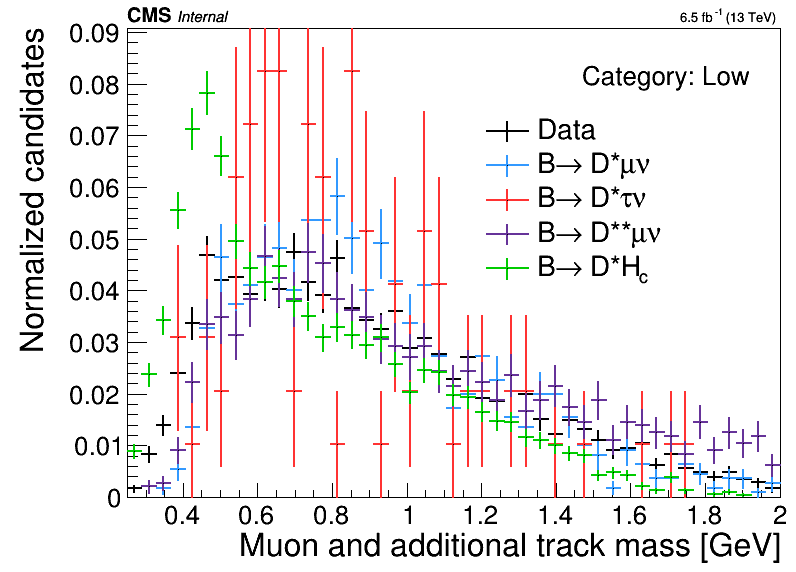

In [24]:
sel = np.logical_and(df['data']['N_goodAddTks'] == 2, df['data']['tkPt_1'] > 0.8)
h = create_TH1D(df['data']['tkMassMuTk_1'][sel], 
                'dataNorm', 
                binning=[45, 0.25, 2.],
                axis_title=['Muon and additional track mass [GeV]', 'Normalized candidates'],
                scale_histo='norm'
               )
h_fit = {}
hdataf = h.Clone('data')
hdataf.Scale(np.sum(sel))
h_fit['data'] = hdataf
hl = [h]
leg = rt.TLegend(0.6, 0.5, 0.9, 0.8)
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
leg.AddEntry(h, label_dic['data'], 'lep')
for n in MCsample.keys():
    sel = np.logical_and(df[n]['N_goodAddTks'] == 2, df[n]['tkPt_1'] > 0.8)
    h = create_TH1D(df[n]['tkMassMuTk_1'][sel], n, 
                binning=h.binning,
                scale_histo='norm'
               )
    h.SetLineColor(col_dic[n])
    leg.AddEntry(h, label_dic[n], 'lep')
    hl.append(h)
    h_fit[n] = h

m = SetMaxToMaxHist(hl)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
leg.Draw()

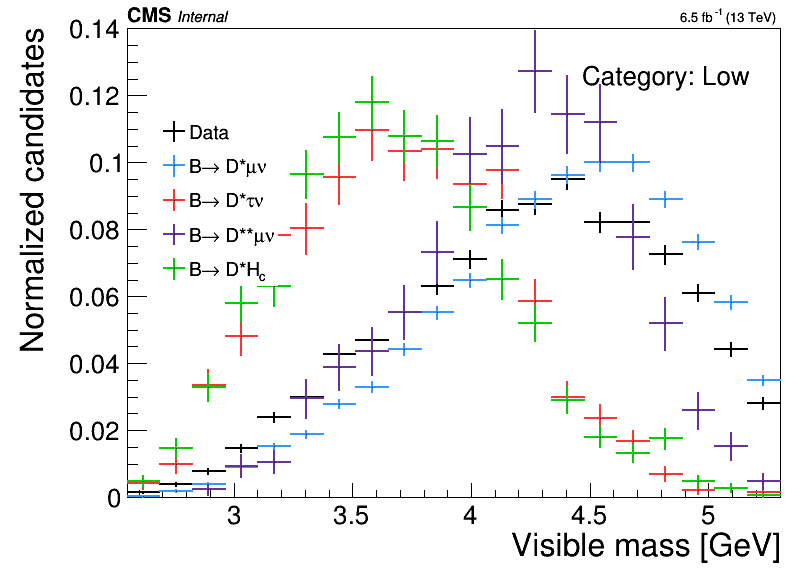

In [25]:
sel = np.logical_and(df['data']['N_goodAddTks'] == 1, df['data']['tkCharge_0'] < 0)
h = create_TH1D(df['data']['tkMassVis_0'][sel], 
                'dataNorm', 
                binning=[20, 2.55, 5.3],
                axis_title=['Visible mass [GeV]', 'Normalized candidates'],
                scale_histo='norm'
               )
h_fit = {}
hdataf = h.Clone('data')
hdataf.Scale(np.sum(sel))
h_fit['data'] = hdataf
hl = [h]
leg = rt.TLegend(0.2, 0.5, 0.35, 0.8)
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
leg.AddEntry(h, label_dic['data'], 'lep')
for n in MCsample.keys():
    sel = np.logical_and(df[n]['N_goodAddTks'] == 1, df[n]['tkCharge_0'] < 0)
    h = create_TH1D(df[n]['tkMassVis_0'][sel], n, 
                binning=h.binning,
                scale_histo='norm'
               )
    h.SetLineColor(col_dic[n])
    leg.AddEntry(h, label_dic[n], 'lep')
    hl.append(h)
    h_fit[n] = h

m = SetMaxToMaxHist(hl)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
leg.Draw()

In [26]:
M = rt.RooRealVar('M', 'Hadronic Mass', h.binning[1], h.binning[2], 'GeV')

data = rt.RooDataHist('Data', 'Data', rt.RooArgList(M), h_fit['data'])
N_data = h_fit['data'].Integral()

dh_mu = rt.RooDataHist('dh_mu', 'mu', rt.RooArgList(M), h_fit['mu'])
pdf_mu = rt.RooHistPdf('pdf_mu', 'pdf_mu', rt.RooArgSet(M), dh_mu)
n_mu = rt.RooRealVar('n_mu', 'N_{#mu}', N_data*0.5, 0, N_data)


dh_Hc = rt.RooDataHist('dh_Hc', 'Hc', rt.RooArgList(M), h_fit['Hc'])
pdf_Hc = rt.RooHistPdf('pdf_Hc', 'pdf_Hc', rt.RooArgSet(M), dh_Hc)
n_Hc = rt.RooRealVar('n_Hc', 'N_{Hc}', 0.5*N_data, 0, N_data)

dh_Dstst = rt.RooDataHist('dh_Dstst', 'Dstst', rt.RooArgList(M), h_fit['Dstst'])
pdf_Dstst = rt.RooHistPdf('pdf_Dstst', 'pdf_Dstst', rt.RooArgSet(M), dh_Dstst)
n_Dstst = rt.RooRealVar('n_Dstst', 'N_{D**}', 0.01*N_data, 0, N_data)

pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_mu, pdf_Hc, pdf_Dstst), rt.RooArgList(n_mu, n_Hc, n_Dstst))
fr = pdf_tot.fitTo(data, rf.PrintLevel(-1), rf.Save())

dof = h.GetNbinsX()-fr.floatParsFinal().getSize()
chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
pval = rt.ROOT.Math.chisquared_cdf_c(chi2.getVal(), dof)
print 'chi2: {:.1f}/{:.0f} {:.3f}'.format(chi2.getVal(), dof, pval)

print 'Total:\nND** = {:.0f} +/- {:.0f} [{:.1f}%]'.format(n_Dstst.getVal(), n_Dstst.getError(), 100*n_Dstst.getError()/n_Dstst.getVal())
print 'Nmu = {:.0f}'.format(n_mu.getVal())
print 'NHc = {:.0f} +/- {:.0f} [{:.1f}%]'.format(n_Hc.getVal(), n_Hc.getError(), 100*n_Hc.getError()/n_Hc.getVal())

chi2: 24.4/17 0.109
Total:
ND** = 1044 +/- 238 [22.8%]
Nmu = 7221
NHc = 1474 +/- 89 [6.1%]


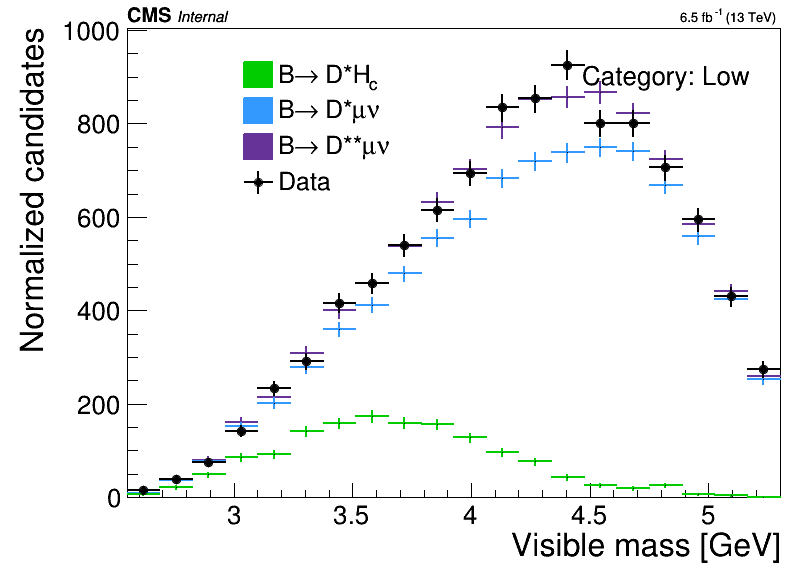

In [27]:
leg = rt.TLegend(0.3, 0.65, 0.5, 0.9)
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

h = h_fit['Hc'].Clone('Hcaux')
h.Scale(n_Hc.getVal())
h.SetFillStyle(1)
h.SetFillColor(col_dic['Hc'])
hl=[h]
leg.AddEntry(h, label_dic['Hc'], 'f')

h = h_fit['mu'].Clone('muaux')
h.Scale(n_mu.getVal())
h.SetFillStyle(1)
h.SetFillColor(col_dic['mu'])
h.Add(hl[0])
hl = [h] + hl
leg.AddEntry(h, label_dic['mu'], 'f')

h = h_fit['Dstst'].Clone('Dststaux')
h.Scale(n_Dstst.getVal())
h.SetFillStyle(1)
h.SetFillColor(col_dic['Dstst'])
h.Add(hl[0])
hl = [h] + hl
leg.AddEntry(h, label_dic['Dstst'], 'f')

leg.AddEntry(h_fit['data'], label_dic['data'], 'lep')
h_fit['data'].SetMarkerStyle(rt.kFullCircle)

m = SetMaxToMaxHist(hl)
c = drawOnCMSCanvas(CMS_lumi, [h_fit['data']] + hl + [h_fit['data']], 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
leg.Draw()